Задача https://www.kaggle.com/datasets/mujtabamatin/dataset-for-machine-failure-detection/data

Набор данных содержит следующие признаки:

- Temperature (°C): Непрерывные данные, отображающие температуру в критических точках машины. Более высокие температуры могут указывать на возможные проблемы, связанные с перегревом.  

- Vibration (Hz): Частота вибраций машины. Аномальные вибрации могут сигнализировать о механическом смещении, дисбалансе или износе.  

- Power Usage (kW): Уровень энергопотребления машины. Скачкообразное увеличение энергопотребления может указывать на повышенную нагрузку или возможные механические неполадки.  

- Humidity (%): Влажность окружающей среды вокруг станка. Высокий уровень влажности может повлиять на производительность станка и со временем привести к поломке.  

- Machine Type: Категориальные данные, указывающие на тип станка (например, "Сверлильный", "Токарный", "Фрезерный"). Различные типы машин могут иметь уникальные схемы отказов.  

Целевая переменная:

- Failure Risk: Двоичная метка, где 0 указывает на нормальную работу, а 1 указывает на то, что машина подвержена риску выхода из строя.

In [339]:
# Импорт
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from get_metrics import get_metrics_classification

import warnings
warnings.filterwarnings("ignore")

RAND = 42

# EDA

In [340]:
df = pd.read_csv('machine_failure_dataset.csv')
df

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
0,74.967142,56.996777,8.649643,20.460962,Mill,1
1,68.617357,54.623168,9.710963,25.698075,Lathe,0
2,76.476885,50.298152,8.415160,27.931972,Drill,1
3,85.230299,46.765316,9.384077,39.438438,Lathe,1
4,67.658466,53.491117,6.212771,32.782766,Drill,1
...,...,...,...,...,...,...
995,67.188997,55.350751,10.154961,30.142288,Lathe,1
996,87.976865,49.867394,10.515505,19.610941,Drill,0
997,76.408429,45.590627,7.516479,28.398511,Mill,0
998,64.288210,49.184665,10.668353,38.216891,Mill,1


In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   1000 non-null   float64
 1   Vibration     1000 non-null   float64
 2   Power_Usage   1000 non-null   float64
 3   Humidity      1000 non-null   float64
 4   Machine_Type  1000 non-null   object 
 5   Failure_Risk  1000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


In [342]:
# Описательные характеристики
df.describe()

,Temperature,Vibration,Power_Usage,Humidity,Failure_Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,70.193321,50.354181,10.011668,29.906404,0.300000
std,9.792159,4.987272,1.966909,5.135663,0.458487
min,37.587327,35.298057,3.960976,15.352757,0.000000
25%,63.524097,46.968792,8.704001,26.312898,0.000000
50%,70.253006,50.315386,9.999498,30.000923,0.000000
75%,76.479439,53.644411,11.321831,33.334727,1.000000
max,108.527315,65.965538,17.852475,46.215465,1.000000


In [343]:
df.describe(include='object')

,Machine_Type
count,1000
unique,3
top,Lathe
freq,338


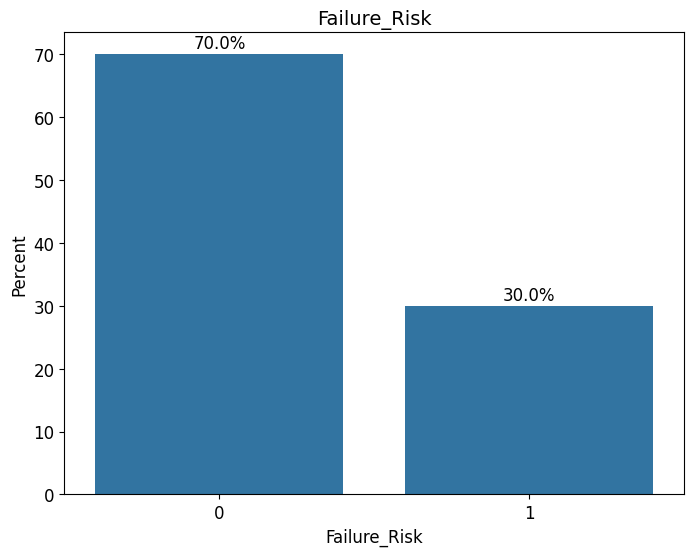

In [344]:
# Проверка на дисбаланс классов
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Failure_Risk', data=df, stat='percent')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 8),
        textcoords='offset points',
        fontsize=12)

plt.title('Failure_Risk', fontsize=14)
plt.xlabel('Failure_Risk', fontsize=12)
plt.ylabel('Percent', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- Есть небольшой дисбаланс

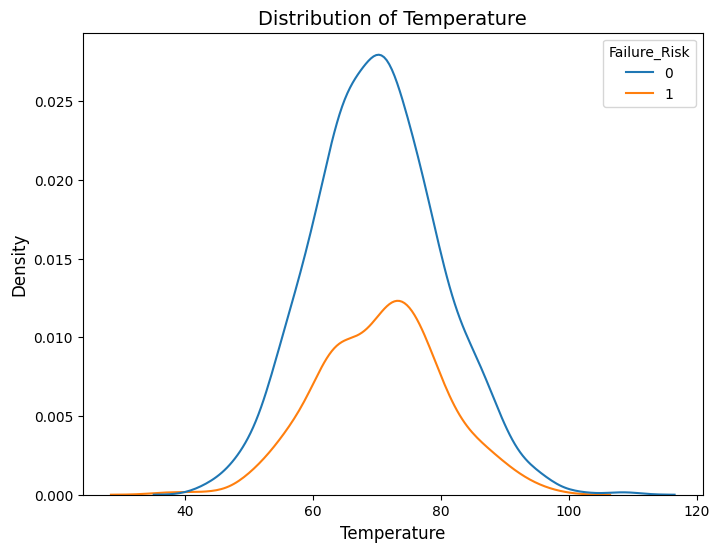

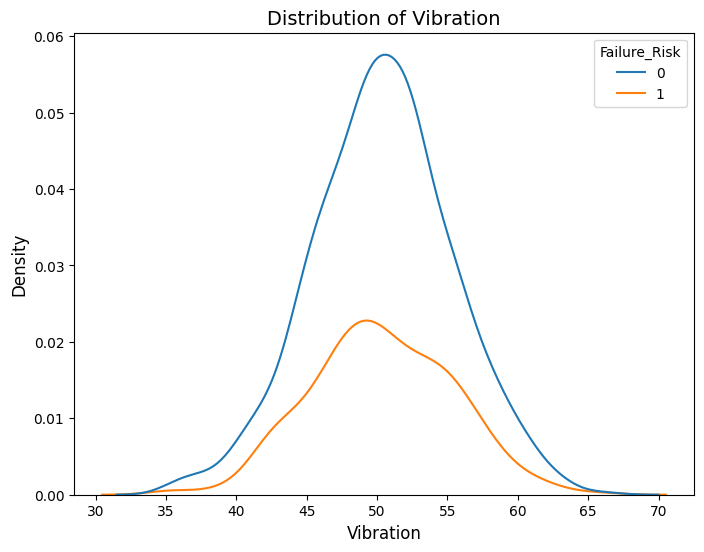

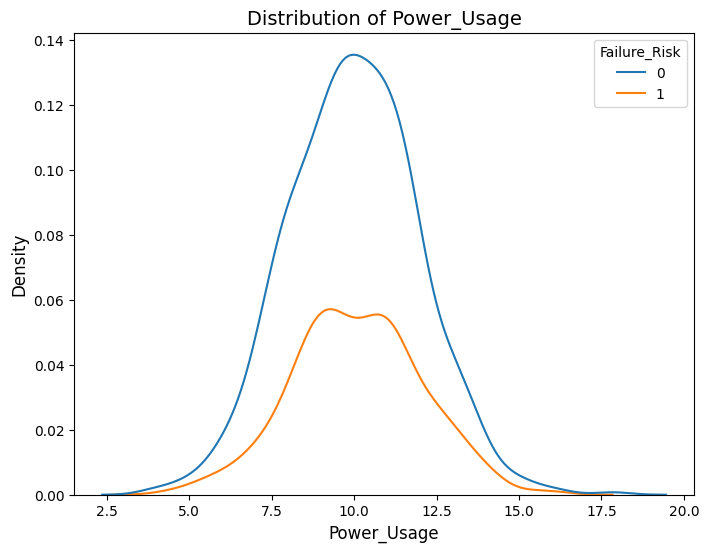

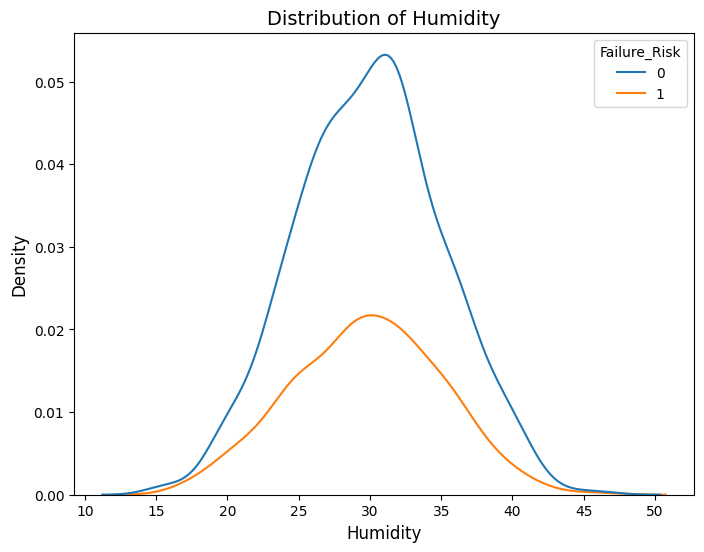

In [345]:
# Распределение признаков
num = ['Temperature', 'Vibration', 'Power_Usage', 'Humidity']
for col in num:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df, x=col, hue='Failure_Risk')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.show()

- Распределения очень схожи, явных различий между двумя классами пока не видно

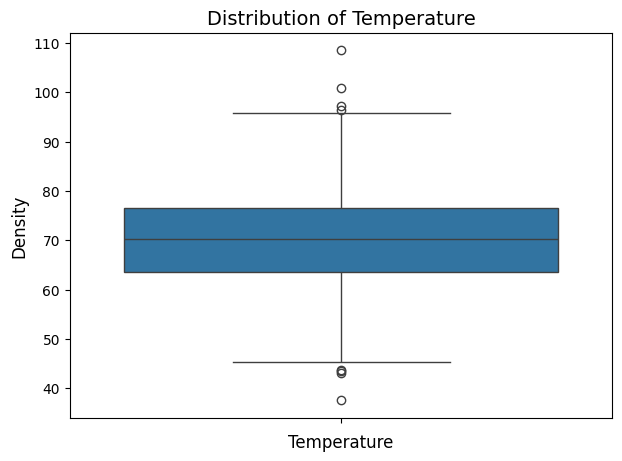

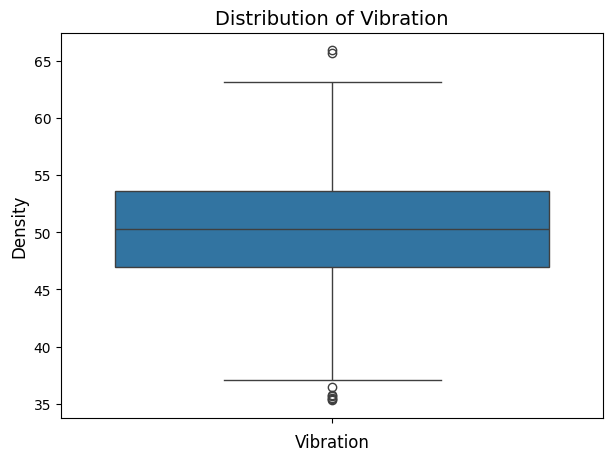

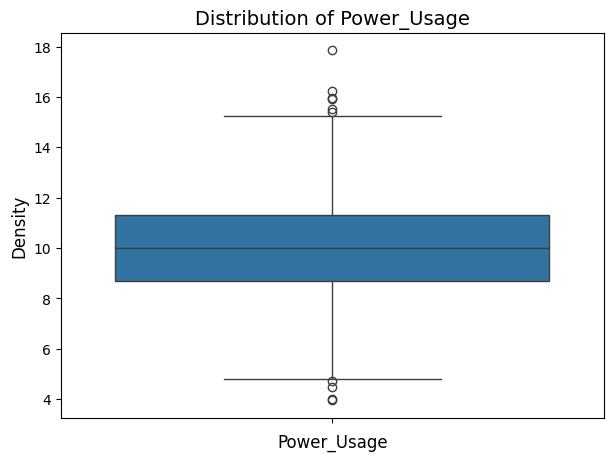

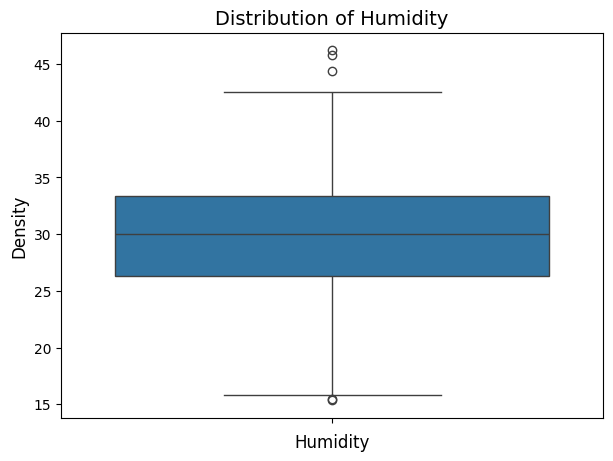

In [346]:
# Построение боксплотов
num = ['Temperature', 'Vibration', 'Power_Usage', 'Humidity']
for col in num:
    plt.figure(figsize=(7, 5))
    sns.boxplot(df[col])
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.show()

- Выбросов не так много.

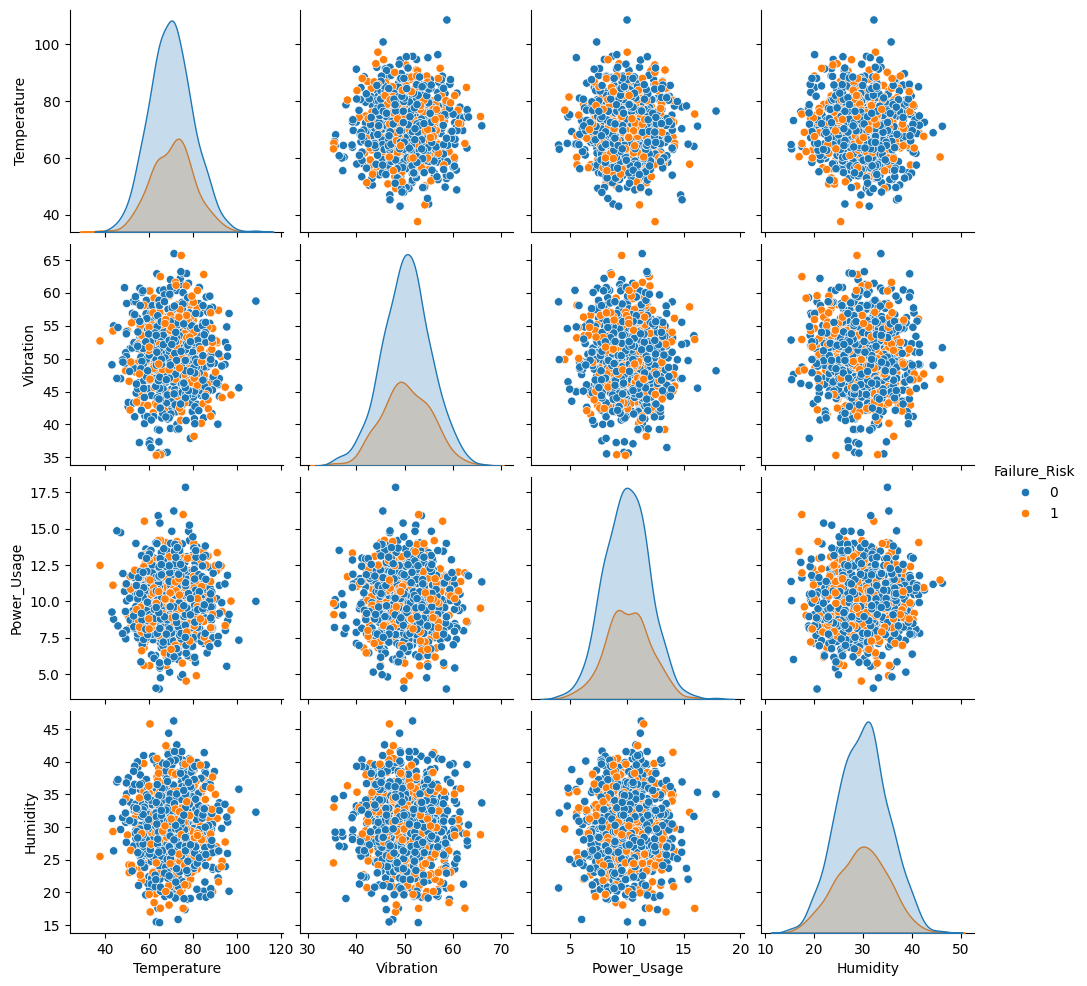

In [347]:
sns.pairplot(df, hue='Failure_Risk')
plt.show()

- Явных визуальных зависимостей не наблюдается

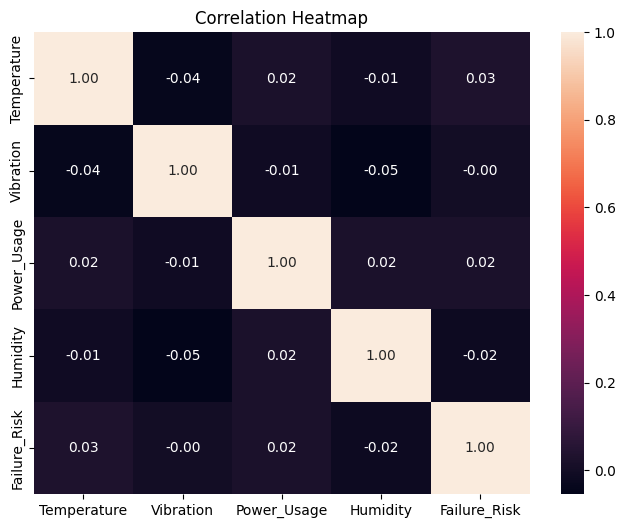

In [ ]:
# Построим heatmap
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

- Очень слабая корреляция по всем признакам.

In [349]:
# Бинаризация категориальных признаков
df = pd.get_dummies(df, dtype='int', drop_first=True)

df

,Temperature,Vibration,Power_Usage,Humidity,Failure_Risk,Machine_Type_Lathe,Machine_Type_Mill
0,74.967142,56.996777,8.649643,20.460962,1,0,1
1,68.617357,54.623168,9.710963,25.698075,0,1,0
2,76.476885,50.298152,8.415160,27.931972,1,0,0
3,85.230299,46.765316,9.384077,39.438438,1,1,0
4,67.658466,53.491117,6.212771,32.782766,1,0,0
...,...,...,...,...,...,...,...
995,67.188997,55.350751,10.154961,30.142288,1,1,0
996,87.976865,49.867394,10.515505,19.610941,0,0,0
997,76.408429,45.590627,7.516479,28.398511,0,0,1
998,64.288210,49.184665,10.668353,38.216891,1,0,1


# Modeling

In [350]:
X = df.drop('Failure_Risk', axis=1)
y = df['Failure_Risk']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RAND)

# Семплирование для устранения дисбаланса классов (undersampling)
undersample = RandomUnderSampler(random_state=RAND)
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [351]:
y_train.value_counts()

Failure_Risk
0    240
1    240
Name: count, dtype: int64

## Decision Tree

In [352]:
tree = DecisionTreeClassifier(random_state=RAND)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_score = tree.predict_proba(X_test)

metrics = get_metrics_classification(y_test,
                                     y_pred,
                                     y_score,
                                     'DecisionTree baseline')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.48,0.466667,0.270833,0.433333,0.333333,18.7427


## Decision Tree GridSearch

In [353]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [6, 8, 10, None],
    'min_samples_leaf': np.arange(10),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'class_weight': ['balanced'],
    'random_state': [RAND]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_tree = GridSearchCV(estimator=tree,
                         param_grid=param_grid, 
                         cv=cv, 
                         scoring='f1_macro', 
                         n_jobs=-1)
grid_tree.fit(X_train, y_train)

print("Лучшие параметры Decision Tree:", grid_tree.best_params_)

Лучшие параметры Decision Tree: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'random_state': 42}


In [354]:
# Обучение на лучших параметрах Decision Tree
tree = DecisionTreeClassifier(**grid_tree.best_params_)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_score = tree.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'DesicionTree grid')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497


## Random Forest

In [355]:
rf = RandomForestClassifier(random_state=RAND)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'RandomForest baseline')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202


## Random Forest GridSearch

In [356]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False, True],
    'class_weight': [{0: 1, 1: w} for w in [1, 3, 5]],
    'random_state': [RAND]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_rf = GridSearchCV(estimator=rf,
                       param_grid=param_grid_rf,
                       cv=cv,
                       scoring='f1_macro', 
                       n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Лучшие параметры Random Forest:", grid_rf.best_params_)

Лучшие параметры Random Forest: {'bootstrap': True, 'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [357]:
# Обучение на лучших параметрах Random Forest
rf = RandomForestClassifier(**grid_rf.best_params_)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'RandomForest grid')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535


## CatBoost

In [358]:
cat = CatBoostClassifier(verbose=0, random_state=RAND)
cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)
y_score = cat.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test, 
                                                         y_pred,
                                                         y_score,
                                                         'CatBoost baseline')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348


## CatBoost GridSearch

In [359]:
param_grid_cat = {
    'iterations': [100, 200],  
    'depth': [4, 6, 8],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'l2_leaf_reg': [1, 3, 5],  
    'scale_pos_weight': [1, 3, 5], 
    'random_strength': [0.1, 1],  
    'bagging_temperature': [0, 1],
    'border_count': [32, 64] ,
    'random_state': [RAND]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_cat = GridSearchCV(estimator=cat,
                        param_grid=param_grid_cat,
                        cv=cv,
                        scoring='f1_macro', 
                        n_jobs=-1)
grid_cat.fit(X_train, y_train)

print("Лучшие параметры CatBoost:", grid_cat.best_params_)

Лучшие параметры CatBoost: {'bagging_temperature': 0, 'border_count': 64, 'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'random_state': 42, 'random_strength': 1, 'scale_pos_weight': 1}


In [360]:
# Обучение на лучших параметрах
cat = CatBoostClassifier(**grid_cat.best_params_)
cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)
y_score = cat.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'CatBoost grid')])
metrics

0:	learn: 0.6852452	total: 812us	remaining: 80.4ms
1:	learn: 0.6802873	total: 1.58ms	remaining: 77.4ms
2:	learn: 0.6695626	total: 2.34ms	remaining: 75.6ms
3:	learn: 0.6642055	total: 3.22ms	remaining: 77.2ms
4:	learn: 0.6568569	total: 3.76ms	remaining: 71.4ms
5:	learn: 0.6503796	total: 4.31ms	remaining: 67.5ms
6:	learn: 0.6412649	total: 5.39ms	remaining: 71.7ms
7:	learn: 0.6354799	total: 6.14ms	remaining: 70.6ms
8:	learn: 0.6298151	total: 6.92ms	remaining: 69.9ms
9:	learn: 0.6230939	total: 7.59ms	remaining: 68.4ms
10:	learn: 0.6194024	total: 8.3ms	remaining: 67.2ms
11:	learn: 0.6181445	total: 8.61ms	remaining: 63.1ms
12:	learn: 0.6134080	total: 9.21ms	remaining: 61.7ms
13:	learn: 0.6078408	total: 10ms	remaining: 61.7ms
14:	learn: 0.6035515	total: 10.7ms	remaining: 60.6ms
15:	learn: 0.5989443	total: 11.7ms	remaining: 61.2ms
16:	learn: 0.5952637	total: 12.5ms	remaining: 61.1ms
17:	learn: 0.5910135	total: 13.1ms	remaining: 59.7ms
18:	learn: 0.5871913	total: 13.7ms	remaining: 58.2ms
19:	lea

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355


## XGB

In [361]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'XGB baseline')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785


## XGB GridSearch

In [362]:
param_grid_xgb = {
    'n_estimators': [100, 200], 
    'max_depth': [3, 5, 7], 
    'learning_rate': [0.01, 0.05, 0.1],  
    'subsample': [0.6, 0.8, 1.0],  # Доля выборки для построения каждого дерева
    'colsample_bytree': [0.6, 0.8, 1.0], # Доля признаков для построения каждого дерева
    'scale_pos_weight': [1, 3, 5], 
    'reg_alpha': [0, 0.1, 1],  # L1-регуляризация (Lasso)
    'reg_lambda': [0, 1, 2],  # L2-регуляризация (Ridge)
    'random_state': [RAND]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_xgb = GridSearchCV(estimator=xgb,
                        param_grid=param_grid_xgb,
                        cv=cv,
                        scoring='f1_macro', 
                        n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Лучшие параметры XGB:", grid_xgb.best_params_)

Лучшие параметры XGB: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.6}


In [363]:
# Обучение на лучших параметрах
xgb = XGBClassifier(**grid_cat.best_params_)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'XGB grid')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548


## LGBMClf

In [364]:
lgbm = LGBMClassifier(random_state=RAND)
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
y_score = lgbm.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test, 
                                                         y_pred, 
                                                         y_score, 
                                                         'LGBM Baseline')])
metrics

[LightGBM] [Info] Number of positive: 240, number of negative: 240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548
0,LGBM Baseline,0.575,0.554286,0.349398,0.483333,0.405594,0.798668


## LGBMClf GridSearch

In [365]:
param_grid_lgbm = {
    'n_estimators': [100],  
    'max_depth': [3, 5, 7], 
    'scale_pos_weight': [1, 3, 5], 
    'reg_alpha': [0, 0.1, 1],  # L1-регуляризация
    'reg_lambda': [0, 1, 2],  # L2-регуляризация
    'random_state': [RAND]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_lgbm = GridSearchCV(estimator=lgbm,
                        param_grid=param_grid_lgbm,
                        cv=cv,
                        scoring='f1_macro', 
                        n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

print("Лучшие параметры LGBM:", grid_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 160, number of negative: 160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 6
[LightGBM] [Info] Number of positive: 160, number of negative: 160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [366]:
# Обучение на лучших параметрах
lgbm = LGBMClassifier(**grid_cat.best_params_)
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
y_score = lgbm.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'LGBM grid')])
metrics

[LightGBM] [Warning] Unknown parameter: border_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] Unknown parameter: bagging_temperature
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: border_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] Unknown parameter: bagging_temperature
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Info] Number of positive: 240, number of negative: 240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 6
[LightGBM] [

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548
0,LGBM Baseline,0.575,0.554286,0.349398,0.483333,0.405594,0.798668
0,LGBM grid,0.575,0.554286,0.349398,0.483333,0.405594,0.798668


In [367]:
"""
Для следующих моделей изменим тестовые и тренировочные выборки, выполнив нормализацию
"""

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RAND)

sc = MinMaxScaler()

num = ['Temperature', 'Vibration', 'Power_Usage', 'Humidity']

X_train[num] = sc.fit_transform(X_train[num])
X_test[num] = sc.transform(X_test[num])

# Семплирование для устранения дисбаланса классов (undersampling)
undersample = RandomUnderSampler(random_state=RAND)
X_train, y_train = undersample.fit_resample(X_train, y_train)

## SVC

In [368]:
svc = SVC(probability=True, random_state=RAND)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
y_score = svc.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred, 
                                                         y_score, 
                                                         'SVC baseline')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548
0,LGBM Baseline,0.575,0.554286,0.349398,0.483333,0.405594,0.798668
0,LGBM grid,0.575,0.554286,0.349398,0.483333,0.405594,0.798668


## SVC GridSearch

In [369]:
param_grid_svc = {
    'C': [0.1, 1, 10], 
    'kernel': ['linear', 'rbf'], 
    'class_weight': ['balanced'], 
    'random_state': [RAND]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_svc = GridSearchCV(estimator=svc,
                        param_grid=param_grid_svc,
                        cv=cv,
                        scoring='f1_macro', 
                        n_jobs=-1)
grid_svc.fit(X_train, y_train)

print("Лучшие параметры SVC:", grid_svc.best_params_)

Лучшие параметры SVC: {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf', 'random_state': 42}


In [370]:
# Обучение на лучших параметрах
svc = SVC(**grid_svc.best_params_, probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
y_score = svc.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'SVC grid')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548
0,LGBM Baseline,0.575,0.554286,0.349398,0.483333,0.405594,0.798668
0,LGBM grid,0.575,0.554286,0.349398,0.483333,0.405594,0.798668


## KNeighbours

In [371]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test, 
                                                         y_pred, 
                                                         y_score, 
                                                         'KNN baseline')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548
0,LGBM Baseline,0.575,0.554286,0.349398,0.483333,0.405594,0.798668
0,LGBM grid,0.575,0.554286,0.349398,0.483333,0.405594,0.798668


## KNN Grid

In [372]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9], 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'], 
    'p': [1, 2]  # Параметр для метрики (1 = Manhattan, 2 = Euclidean)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_knn = GridSearchCV(estimator=knn,
                        param_grid=param_grid_knn,
                        cv=cv,
                        scoring='f1_macro', 
                        n_jobs=-1)
grid_knn.fit(X_train, y_train)

print("Лучшие параметры KNN:", grid_knn.best_params_)

Лучшие параметры KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


In [373]:
# Обучение на лучших параметрах
knn = KNeighborsClassifier(**grid_knn.best_params_)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'KNN grid')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548
0,LGBM Baseline,0.575,0.554286,0.349398,0.483333,0.405594,0.798668
0,LGBM grid,0.575,0.554286,0.349398,0.483333,0.405594,0.798668


## Logistic Regression

In [374]:
lg = LogisticRegression(random_state=RAND)
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test, 
                                                         y_pred, 
                                                         y_score, 
                                                         'LogisticRegression Baseline')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548
0,LGBM Baseline,0.575,0.554286,0.349398,0.483333,0.405594,0.798668
0,LGBM grid,0.575,0.554286,0.349398,0.483333,0.405594,0.798668


## Logistic Regression Grid

In [375]:
cv = StratifiedKFold(3, shuffle=True)

param_grid_lg = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': ['balanced'],
    'random_state': [RAND]
}

grid_lg = GridSearchCV(estimator=lg,
                       param_grid=param_grid_lg,
                       cv=cv,
                       scoring='f1_macro',
                       n_jobs=-1)
grid_lg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'class_weight': ['balanced'],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='f1_macro')

In [376]:
lg = LogisticRegression(**grid_lg.best_params_)
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

metrics = pd.concat([metrics, get_metrics_classification(y_test,
                                                         y_pred,
                                                         y_score,
                                                         'LogisticRegression grid')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,DecisionTree baseline,0.480,0.466667,0.270833,0.433333,0.333333,18.742700
0,DesicionTree grid,0.495,0.506845,0.297030,0.500000,0.372671,2.302497
0,RandomForest baseline,0.575,0.527679,0.341772,0.450000,0.388489,0.712202
0,RandomForest grid,0.560,0.518988,0.333333,0.466667,0.388889,0.715535
0,CatBoost baseline,0.615,0.562976,0.395062,0.533333,0.453901,0.704348
0,CatBoost grid,0.555,0.544643,0.325301,0.450000,0.377622,0.711355
0,XGB baseline,0.575,0.531429,0.356322,0.516667,0.421769,0.975785
0,XGB grid,0.565,0.522619,0.351648,0.533333,0.423841,0.787548
0,LGBM Baseline,0.575,0.554286,0.349398,0.483333,0.405594,0.798668
0,LGBM grid,0.575,0.554286,0.349398,0.483333,0.405594,0.798668


In [377]:
metrics.set_index('model').drop('Logloss', axis=1).style.highlight_max(axis=0, color='lightyellow')

,Accuracy,ROC_AUC,Precision,Recall,f1
model,,,,,
DecisionTree baseline,0.480000,0.466667,0.270833,0.433333,0.333333
DesicionTree grid,0.495000,0.506845,0.297030,0.500000,0.372671
RandomForest baseline,0.575000,0.527679,0.341772,0.450000,0.388489
RandomForest grid,0.560000,0.518988,0.333333,0.466667,0.388889
CatBoost baseline,0.615000,0.562976,0.395062,0.533333,0.453901
CatBoost grid,0.555000,0.544643,0.325301,0.450000,0.377622
XGB baseline,0.575000,0.531429,0.356322,0.516667,0.421769
XGB grid,0.565000,0.522619,0.351648,0.533333,0.423841
LGBM Baseline,0.575000,0.554286,0.349398,0.483333,0.405594


Вывод  
На основе проведённого анализа различных моделей с использованием как baseline-версий, так и оптимизации через GridSearch, не удалось достичь значительного улучшения метрик. Максимальный ROC_AUC составил 0.583 (KNN baseline), CatBoost baseline также близок к результатам knn, что по факту немного лучше случайного угадывания. Из этого могу сделать вывод, что текущего объёма данных недостаточно для эффективного обучения.